관계형 추론(relational reasoning)을 위해 DeepMind가 제안한 신경망 모델에 대해서 알아보고자 합니다. 이 모델은 [A simple neural network module for relational reasoning](https://arxiv.org/pdf/1706.01427.pdf)이란 논문에서 소개되었고, 컨볼루션 신경망에 관계 네트워크(Relation Networks, RN)를 추가하여 어떻게 객체와 그 관계에 대해 추론하는 지 설명되어 있습니다. 시각기반의 질의응답 문제에 대해 탁월한 성능을 보이고 있다고 합니다.

본 스터디에서는 [Alan-Lee123](https://github.com/Alan-Lee123/relation-network/blob/master/README.md) 사이트에서 구현된 케라스 코드를 실행시키면서 분석해보겠습니다. 사용된 데이터셋은 [Cornell NLVR](https://github.com/cornell-lic/nlvr)이라고 불리는 시각기반의 질의응답 데이터셋입니다.

---

### 관계형 추론이란

관계형이란 의미는 객체 간의 관계에 대해서 인지를 할 수 있는 가를 얘기합니다. 아래 그림을 보면, 비관계형 질문과 관계형 질문이 있습니다. 비관계형 질문은 특정 객체의 속성에 대한 추론이 필요한 방면, 관계형 질문은 객체 간의 관계에 대한 추론이 필요합니다.

![paper](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_paper1.png)
(Ref, arXiv:1706.01427)


공동 훈련을 통해 RN은 CNN 및 LSTM의 상향 표현에 영향을 미치고 모양을 형성하여 관계형 추론에 활용할 수있는 암시 적 객체와 같은 표현을 생성 할 수 있습니다.

In [1]:
import json
import numpy as np
import os
from PIL import Image
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras.preprocessing.text

def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

EMBEDDING_DIM = 50
tokenizer = Tokenizer()


def load_data(path):
    f = open(path, 'r')
    data = []
    for l in f:
        jn = json.loads(l)
        s = jn['sentence']
        idn = jn['identifier']
        la = int(jn['label'] == 'true')
        data.append([idn, s, la])
    return data


def init_tokenizer(sdata):
    texts = [t[1] for t in sdata]
    tokenizer.fit_on_texts(texts)


def tokenize_data(sdata, mxlen):
    texts = [t[1] for t in sdata]
    seqs = tokenizer.texts_to_sequences(texts)
    seqs = pad_sequences(seqs, mxlen)
    data = {}
    for k in range(len(sdata)):
        data[sdata[k][0]] = [seqs[k], sdata[k][2]]
    return data


def load_images(path, sdata, debug=False):
    data = {}
    cnt = 0
    N = 1000
    for lists in os.listdir(path):
        p = os.path.join(path, lists)
        
        if not os.path.isdir(p):
            continue
            
        for f in os.listdir(p):
            cnt += 1
            if debug and cnt > N:
                break
            im_path = os.path.join(p, f)
            im = Image.open(im_path)
            im = im.convert('RGB')
            im = im.resize((200, 50))
            im = np.array(im)
            idf = f[f.find('-') + 1:f.rfind('-')]
            data[f] = [im] + sdata[idf]
    ims, ws, labels = [], [], []
    for key in data:
        ims.append(data[key][0])
        ws.append(data[key][1])
        labels.append(data[key][2])
    data.clear()
    idx = np.arange(0, len(ims), 1)
    np.random.shuffle(idx)
    ims = [ims[t] for t in idx]
    ws = [ws[t] for t in idx]
    labels = [labels[t] for t in idx]
    ims = np.array(ims, dtype=np.float32)
    ws = np.array(ws, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return ims, ws, labels


def get_embeddings_index():
    embeddings_index = {}
    path = './warehouse/word2vec/glove.6B.50d.txt'
    f = open(path, 'r')#, errors='ignore')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index


def get_embedding_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def embedding_layer(word_index, embedding_index, sequence_len):
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    return Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=sequence_len,
                     trainable=False)

Using TensorFlow backend.


In [2]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding, LSTM, Bidirectional, Lambda, Concatenate, Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization, regularizers
from keras.optimizers import Adam, RMSprop
import gc

import subprocess
import pickle

mxlen = 32
embedding_dim = 50
lstm_unit = 64
MLP_unit = 128
epochs = 50
batch_size = 256
l2_norm = 0.01

train_json = './warehouse/nlvr/train/train.json'
train_img_folder = './warehouse/nlvr/train/images'
test_json = './warehouse/nlvr/dev/dev.json'
test_img_folder = './warehouse/nlvr/dev/images'

data = load_data(train_json)
init_tokenizer(data)
data = tokenize_data(data, mxlen)
imgs, ws, labels = load_images(train_img_folder, data)
data.clear()

test_data = load_data(test_json)
test_data = tokenize_data(test_data, mxlen)
test_imgs, test_ws, test_labels = load_images(test_img_folder, test_data)
test_data.clear()

imgs_mean = np.mean(imgs)
imgs_std = np.std(imgs - imgs_mean)
imgs = (imgs - imgs_mean) / imgs_std

test_imgs = (test_imgs - imgs_mean) / imgs_std

In [3]:
def bn_layer(x, conv_unit):
    def f(inputs):
        md = Conv2D(x, (conv_unit, conv_unit), padding='same', kernel_initializer='he_normal')(inputs)
        md = BatchNormalization()(md)
        return Activation('relu')(md)

    return f


def conv_net(inputs):
    model = bn_layer(16, 3)(inputs)
    model = MaxPooling2D((4, 4), 4)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((3, 3), 3)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((2, 2), 2)(model)
    model = bn_layer(32, 3)(model)
    return model

In [4]:
input1 = Input((50, 200, 3))
input2 = Input((mxlen,))
cnn_features = conv_net(input1)
embedding_layer = embedding_layer(tokenizer.word_index, get_embeddings_index(), mxlen)
embedding = embedding_layer(input2)
# embedding = Embedding(mxlen, embedding_dim)(input2)
bi_lstm = Bidirectional(LSTM(lstm_unit, implementation=2, return_sequences=False,
                             recurrent_regularizer=regularizers.l2(l2_norm), recurrent_dropout=0.25))
lstm_encode = bi_lstm(embedding)
shapes = cnn_features.shape
w, h = shapes[1], shapes[2]

In [5]:
def slice_1(t):
    return t[:, 0, :, :]


def slice_2(t):
    return t[:, 1:, :, :]


def slice_3(t):
    return t[:, 0, :]


def slice_4(t):
    return t[:, 1:, :]

slice_layer1 = Lambda(slice_1)
slice_layer2 = Lambda(slice_2)
slice_layer3 = Lambda(slice_3)
slice_layer4 = Lambda(slice_4)

features = []
for k1 in range(w):
    features1 = slice_layer1(cnn_features)
    cnn_features = slice_layer2(cnn_features)
    for k2 in range(h):
        features2 = slice_layer3(features1)
        features1 = slice_layer4(features1)
        features.append(features2)

relations = []
concat = Concatenate()
for feature1 in features:
    for feature2 in features:
        relations.append(concat([feature1, feature2, lstm_encode]))


def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f


def get_MLP(n):
    r = []
    for k in range(n):
        s = stack_layer([
            Dense(MLP_unit),
            BatchNormalization(),
            Activation('relu')
        ])
        r.append(s)
    return stack_layer(r)


def bn_dense(x):
    y = Dense(MLP_unit)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    return y


g_MLP = get_MLP(3)

mid_relations = []
for r in relations:
    mid_relations.append(g_MLP(r))
combined_relation = Add()(mid_relations)

rn = bn_dense(combined_relation)
rn = bn_dense(rn)
pred = Dense(1, activation='sigmoid')(rn)

model = Model(inputs=[input1, input2], outputs=pred)
optimizer = Adam(lr=3e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

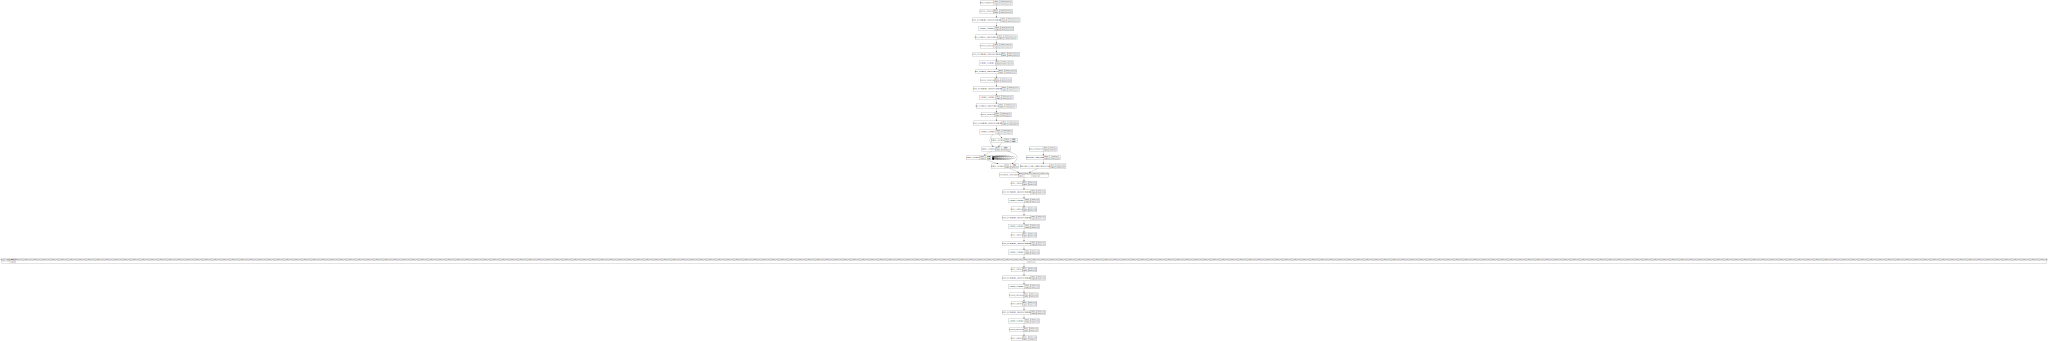

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:

model.fit([imgs, ws], labels, validation_data=[[test_imgs, test_ws], test_labels],
          epochs=epochs, batch_size=batch_size)

Train on 74460 samples, validate on 5934 samples
Epoch 1/50
74460/74460 [==============================] - 3981s - loss: 1.0313 - acc: 0.5506 - val_loss: 0.7847 - val_acc: 0.5484
Epoch 2/50
74460/74460 [==============================] - 1255s - loss: 0.7153 - acc: 0.5630 - val_loss: 0.6877 - val_acc: 0.5425
Epoch 3/50
74460/74460 [==============================] - 1027s - loss: 0.6576 - acc: 0.5740 - val_loss: 0.6664 - val_acc: 0.5693
Epoch 4/50
74460/74460 [==============================] - 1015s - loss: 0.6421 - acc: 0.5805 - val_loss: 0.6624 - val_acc: 0.5644
Epoch 5/50
74460/74460 [==============================] - 1021s - loss: 0.6343 - acc: 0.5920 - val_loss: 0.6584 - val_acc: 0.5797
Epoch 6/50
74460/74460 [==============================] - 1015s - loss: 0.6279 - acc: 0.6028 - val_loss: 0.6603 - val_acc: 0.5848
Epoch 7/50
74460/74460 [==============================] - 1012s - loss: 0.6210 - acc: 0.6134 - val_loss: 0.6580 - val_acc: 0.5881
Epoch 8/50
74460/74460 [=================

In [8]:
### Test
print(model.evaluate([test_imgs, test_ws], test_labels, batch_size=128))

#model.save('model')
#tokenizer_file = open('tokenizer', 'wb')
#pickle.dump(prepare.tokenizer, tokenizer_file)
#tokenizer_file.close()
#gc.collect()

5934/5934 [==============================] - 36s    
[3.3527991929197296, 0.51634647792382882]


In [ ]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding, \
    LSTM, Bidirectional, Lambda, Concatenate, Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization, regularizers
from keras.optimizers import Adam, RMSprop
import gc
import prepare
import subprocess
import pickle



def bn_layer(x, conv_unit):
    def f(inputs):
        md = Conv2D(x, (conv_unit, conv_unit), padding='same', kernel_initializer='he_normal')(inputs)
        md = BatchNormalization()(md)
        return Activation('relu')(md)

    return f

def conv_net(inputs):
    model = bn_layer(16, 3)(inputs)
    model = MaxPooling2D((4, 4), 4)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((3, 3), 3)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((2, 2), 2)(model)
    model = bn_layer(32, 3)(model)
    return model

def slice_1(t):
    return t[:, 0, :, :]


def slice_2(t):
    return t[:, 1:, :, :]


def slice_3(t):
    return t[:, 0, :]


def slice_4(t):
    return t[:, 1:, :]


def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f


def get_MLP(n):
    r = []
    for k in range(n):
        s = stack_layer([
            Dense(MLP_unit),
            BatchNormalization(),
            Activation('relu')
        ])
        r.append(s)
    return stack_layer(r)


def bn_dense(x):
    y = Dense(MLP_unit)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    return y

In [ ]:
mxlen = 32
embedding_dim = 50
lstm_unit = 64
MLP_unit = 128
epochs = 50
batch_size = 256
l2_norm = 0.01

train_json = './warehouse/nlvr/train/train.json'
train_img_folder = './warehouse/nlvr/train/images'
test_json = './warehouse/nlvr/dev/dev.json'
test_img_folder = './warehouse/nlvr/dev/images'

data = load_data(train_json)
init_tokenizer(data)

data = tokenize_data(data, mxlen)
imgs, ws, labels = load_images(train_img_folder, data)
data.clear()

test_data = load_data(test_json)
test_data = tokenize_data(test_data, mxlen)
test_imgs, test_ws, test_labels = load_images(test_img_folder, test_data)
test_data.clear()

imgs_mean = np.mean(imgs)
imgs_std = np.std(imgs - imgs_mean)
imgs = (imgs - imgs_mean) / imgs_std

test_imgs = (test_imgs - imgs_mean) / imgs_std

In [ ]:

input1 = Input((50, 200, 3))
input2 = Input((mxlen,))
cnn_features = conv_net(input1)
embedding_layer = embedding_layer(tokenizer.word_index, get_embeddings_index(), mxlen)
embedding = embedding_layer(input2)
# embedding = Embedding(mxlen, embedding_dim)(input2)
bi_lstm = Bidirectional(LSTM(lstm_unit, implementation=2, return_sequences=False,
                             recurrent_regularizer=regularizers.l2(l2_norm), recurrent_dropout=0.25))

lstm_encode = bi_lstm(embedding)
shapes = cnn_features.shape
w, h = shapes[1], shapes[2]

slice_layer1 = Lambda(slice_1)
slice_layer2 = Lambda(slice_2)
slice_layer3 = Lambda(slice_3)
slice_layer4 = Lambda(slice_4)

features = []
for k1 in range(w):
    features1 = slice_layer1(cnn_features)
    cnn_features = slice_layer2(cnn_features)
    for k2 in range(h):
        features2 = slice_layer3(features1)
        features1 = slice_layer4(features1)
        features.append(features2)

relations = []
concat = Concatenate()
for feature1 in features:
    for feature2 in features:
        relations.append(concat([feature1, feature2, lstm_encode]))

g_MLP = get_MLP(3)

mid_relations = []
for r in relations:
    mid_relations.append(g_MLP(r))
combined_relation = Add()(mid_relations)

rn = bn_dense(combined_relation)
rn = bn_dense(rn)
pred = Dense(1, activation='sigmoid')(rn)

model = Model(inputs=[input1, input2], outputs=pred)
optimizer = Adam(lr=3e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

---

### 현실적인 문제

[컨볼루션 신경망 모델 만들어보기](https://tykimos.github.io/Keras/2017/03/08/CNN_Getting_Started/) 강좌에서 사용하였던 원, 사각형, 삼각형 데이터셋을 예제로 살펴보겠습니다. 구성은 훈련셋과 시험셋으로 되어 있는 데, 아래 그림은 훈련셋입니다.

#### 훈련셋
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_1.png)

그리고 아래 그림은 시험셋입니다. 훈련셋과 시험셋은 모두 한사람(제가) 그린 것이라 거의 비슷합니다. 그래서 그런지 100% 정확도의 좋은 결과를 얻었나 봅니다.

#### 시험셋
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_2.png)

100% 정확도를 얻은 모델이니 원, 사각형, 삼각형을 그려주면 다 분류를 해보겠다며 지인에게 자랑을 해봅니다. 그래서 지인이 그려준 시험셋은 다음과 같습니다.

#### 도전 시험셋
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_3.png)

막상 시험셋을 받아보니 자신감이 없어지면서 여러가지 생각이 듭니다.

- 아, 이것도 원, 사각형, 삼각형이구나
- 왜 이런 데이터를 진작에 학습시키지 않았을까?
- 새로 받은 시험셋 일부를 학습시켜볼까?
- 이렇게 간단한 문제도 개발과 현실과의 차이가 이렇게 나는데, 실제 문제는 더 상황이 좋지 않겠지?

결국 하나의 결론에 도달합니다.

    개발자가 시험셋을 만들면 안된다.

하지만 어떠한 문제에서도 미래에 들어올 데이터에 대해서는 알 수가 없기 때문에, 비슷한 상황일 것 같습니다. 먼저 도전 시험셋으로 시험한 결과를 살펴본 뒤, 한정적인 훈련셋을 이용하여 최대한 발생할 수 있는 경우을 고려하여 훈련셋을 만드는 방법인 `데이터 부풀리기`에 대해서 알아보겠습니다.

---

### 기존 모델 결과보기

[컨볼루션 신경망 모델 만들어보기](https://tykimos.github.io/Keras/2017/03/08/CNN_Getting_Started/) 강좌에서 사용했던 모델을 그대로 가지고 왔습니다. 제가 만든 시험셋에서는 결과가 100%나왔는데, 도전 시험셋으론 어떤 결과가 나오는 지 테스트해보겠습니다.

In [ ]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(3)

from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

# 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=200,
        validation_data=test_generator,
        validation_steps=5)

# 모델 평가하기
print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 5)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(
            test_generator, 
            steps = 5)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

수행결과는 40%입니다. 세개 중 하나 찍는 문제인데도 불구하고 50%로 못 넘깁니다. 오버피팅이 제대로 된 모델이라고 볼 수 있습니다.

---

### 데이터 부풀리기

케라스에서는 `ImageDataGenerator` 함수를 통해서 데이터 부풀리기 기능을 제공합니다. [keras.io](https://keras.io/preprocessing/image/#imagedatagenerator) 페이지를 보면, 아래와 같은 옵션으로 데이터 부풀리기를 할 수 있습니다.

    keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=K.image_data_format())

그럼 훈련셋 중 하나인 삼각형을 골라 데이터 부풀리기를 해보겠습니다. 원본이 되는 삼각형은 다음과 같습니다.

![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_4.png)

이 삼각형을 ImageDataGenerator 함수을 이용하여 각 파라미터별로 어떻게 부풀리기를 하는 지 살펴보겠습니다.

#### rotation_range = 90
지정된 각도 범위내에서 임의로 원본이미지를 회전시킵니다. 단위는 도이며, 정수형입니다. 예를 들어 90이라면 0도에서 90도 사이에 임의의 각도로 회전시킵니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_rotate.png)
                                   
#### width_shift_range = 0.1
지정된 수평방향 이동 범위내에서 임의로 원본이미지를 이동시킵니다. 수치는 전체 넓이의 비율(실수)로 나타냅니다. 예를 들어 0.1이고 전체 넓이가 100이면, 10픽셀 내외로 좌우 이동시킵니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_width_shift.png)

#### height_shift_range = 0.1
지정된 수직방향 이동 범위내에서 임의로 원본이미지를 이동시킵니다. 수치는 전체 높이의 비율(실수)로 나타냅니다. 예를 들어 0.1이고 전체 높이가 100이면, 10픽셀 내외로 상하 이동시킵니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_height_shift.png)

#### shear_range = 0.5
밀림 강도 범위내에서 임의로 원본이미지를 변형시킵니다. 수치는 시계반대방향으로 밀림 강도를 라디안으로 나타냅니다. 예를 들어 0.5이라면, 0.5 라이안내외로 시계반대방향으로 변형시킵니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_shear.png)

#### zoom_range = 0.3
지정된 확대/축소 범위내에서 임의로 원본이미지를 확대/축소합니다. "1-수치"부터 "1+수치"사이 범위로 확대/축소를 합니다. 예를 들어 0.3이라면, 0.7배에서 1.3배 크기 변화를 시킵니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_zoom.png)

#### horizontal_flip = True
수평방향으로 뒤집기를 합니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_horizontal_flip.png)

#### vertical_flip = True
수직방향으로 뒤집기를 합니다.
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_vertical_flip.png)

아래 코드는 ImageDataGenerator함수를 이용하여 지정된 파라미터로 원본이미지에 대해 데이터 부풀리기를 수행한 후 그 결과를 특정 폴더에 저장하는 코드입니다. 여러 파라미터를 사용하였기 때문에 이를 혼합하여 데이터 부풀리기를 수행합니다. 즉 확대/축소도 하고 좌우 이동도 지정하였다면, 축소하면서 좌로 이동된 이미지도 생성됩니다.

In [ ]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# 데이터셋 불러오기
data_aug_gen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.5,
                                  zoom_range=[0.8, 2.0],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
                                   
img = load_img('warehouse/hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

# 이 for는 무한으로 반복되기 때문에 우리가 원하는 반복횟수를 지정하여, 지정된 반복횟수가 되면 빠져나오도록 해야합니다.
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='warehouse/preview', save_prefix='tri', save_format='png'):
    i += 1
    if i > 30: 
        break

위 코드로 데이터 부풀리기가 수행된 결과 이미지는 다음과 같습니다. 지인이 만든 도전 시험셋 중 비슷한 것들도 보입니다.

![data](http://tykimos.github.com/Keras/warehouse/2017-3-8-CNN_Data_Augmentation_5_combination.png)

---

### 개선 모델 결과보기

데이터 부풀리기를 하기 위해서는 기존 코드에서 아래 코드를 추가합니다. 각 파라미터 설정 값에 따라 결과가 다르기 나오니, 실제 데이터에 있을만한 수준으로 적정값을 지정하셔야 합니다.

In [ ]:
# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.5,
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

수정된 전체 코드는 다음과 같습니다. 참고로 시험셋은 데이터 부풀리기를 할 필요가 없으니, test_datagen 객체 생성 시에는 별도의 파라미터를 추가하지 않았습니다. 그리고 fit_generator함수에서 steps_per_epoch의 값은 기존 15개에서 더 많은 수 (현재 예는 1500개)로 설정합니다. batch_size * steps_per_epoch가 전체 샘플 수 인데, 데이터 부풀리기를 하지 않을 때는 기존의 15개의 배치사이즈(3개)로 전체 45개를 모두 학습에 사용할 수 있지만, ImageDataGenerator함수를 통해 데이터 부풀리기는 할 때는 하나의 샘플로 여러 개의 결과를 얻기 때문에 요청하는 데로 무한의 샘플이 제공됩니다. 여기서는 100배 정도인 1500개로 설정했습니다.

In [ ]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(3)

from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=200,
        validation_data=test_generator,
        validation_steps=5)

# 모델 평가하기
print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 5)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(
            test_generator, 
            steps = 5)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

73.33%의 정확도를 얻었습니다. 만족할만한 수준은 아니지만, 도전 시험셋으로 기존 모델을 시험했을 때의 결과가 50%를 못 미치는 수준에 비하면 비약적인 개선이 일어났습니다. 이는 동일한 모델을 사용하면서 훈련 데이터만 부풀려서 학습을 시켰을 뿐인데 성능 향상이 일어났습니다.

---

### 결론

원, 삼각형, 사각형을 분류하는 간단한 문제에서도 개발 모델이 현실에 적용하기 위해서는 어떠한 어려움이 있는 지 알게되었습니다. 그리고 이를 극복하는 방안으로 데이터 부풀리기 방법에 대해서 알아보고, 각 파라미터 별로 어떻게 데이터를 부풀리는 지 생성된 이미지를 통해 살펴보왔습니다. 훈련셋이 충분하지 않거나 시험셋의 다양한 특성을 반영되어 있지 않다면 데이터 부풀리기 방법은 성능 개선에 큰 도움을 줄 수 있습니다. 

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* 이전 : [딥러닝 모델 이야기/컨볼루션 신경망 레이어 이야기](https://tykimos.github.io/Keras/2017/01/27/CNN_Layer_Talk/)
* 다음 : [딥러닝 모델 이야기/순환 신경망 레이어 이야기]